# Import libraries

In [77]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Conv2D,MaxPooling2D,Dense
import cv2
import os
import glob

# Loading Images Data (Storing as X)


In [78]:
# Load Dataset
img_dir = "../input/car-plate-detection/images" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*g')
files = glob.glob(data_path)
files.sort() #We sort the images in alphabetical order to match them to the xml files containing the annotations of the bounding boxes


# storing in X
IMAGE_SIZE = 224
X=[]
for f1 in files:
    img = cv2.imread(f1)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    X.append(np.array(img))
    

In [79]:
X[0]

array([[[135, 108,  54],
        [158, 124,  45],
        [179, 146,  79],
        ...,
        [ 41,  43,  42],
        [ 43,  41,  40],
        [ 37,  36,  34]],

       [[128, 105,  53],
        [154, 120,  41],
        [149, 119,  53],
        ...,
        [ 46,  46,  45],
        [ 42,  44,  41],
        [ 35,  37,  34]],

       [[127, 108,  63],
        [153, 121,  43],
        [153, 126,  63],
        ...,
        [ 44,  41,  41],
        [ 47,  49,  45],
        [ 36,  38,  34]],

       ...,

       [[ 40,  48,  71],
        [ 41,  49,  72],
        [ 42,  50,  73],
        ...,
        [ 43,  62,  99],
        [ 46,  67, 101],
        [ 47,  67, 102]],

       [[ 44,  52,  75],
        [ 43,  51,  74],
        [ 41,  49,  72],
        ...,
        [ 42,  62,  99],
        [ 47,  66, 103],
        [ 48,  67, 104]],

       [[ 44,  52,  75],
        [ 41,  50,  73],
        [ 39,  47,  70],
        ...,
        [ 45,  64, 102],
        [ 45,  64, 102],
        [ 46,  65, 103]]

# Annotation Labels

We create the variable y containing all the bounding boxe annotations (label). 
Before that, we will have to resize the annotations so that it fits the new size of the images (200*200). We create a function resizeannotation for that. 

In [80]:
from lxml import etree

def resizeannotation(f):
    tree = etree.parse(f)
    for dim in tree.xpath("size"):
        width = int(dim.xpath("width")[0].text)
        height = int(dim.xpath("height")[0].text)
    for dim in tree.xpath("object/bndbox"):
        xmin = int(dim.xpath("xmin")[0].text)/(width/IMAGE_SIZE)
        ymin = int(dim.xpath("ymin")[0].text)/(height/IMAGE_SIZE)
        xmax = int(dim.xpath("xmax")[0].text)/(width/IMAGE_SIZE)
        ymax = int(dim.xpath("ymax")[0].text)/(height/IMAGE_SIZE)
    return [int(xmax), int(ymax), int(xmin), int(ymin)]

In [81]:
path = '../input/car-plate-detection/annotations'
text_files = ['../input/car-plate-detection/annotations/'+f for f in sorted(os.listdir(path))]
y=[]
for i in text_files:
    y.append(resizeannotation(i))

In [82]:
y[0]

[187, 144, 101, 104]

In [83]:
np.array(X).shape

(433, 224, 224, 3)

In [84]:
np.array(y).shape

(433, 4)

# Data Visualization

And we display the first eighteen image of the dataset : 

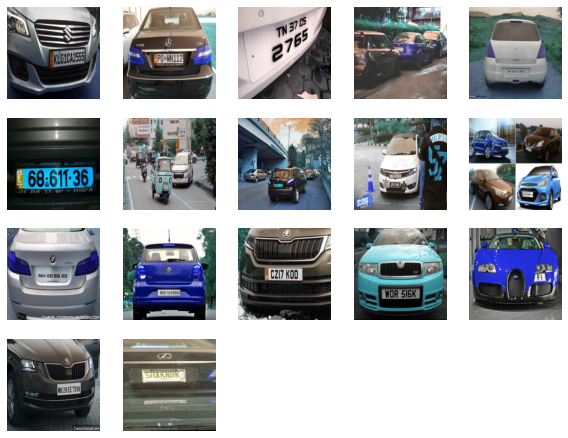

In [85]:
plt.figure(figsize=(10,20))
for i in range(0,17) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    plt.imshow(X[i])

# Exploring Plates With CV2
We can draw the rectangle containing the license plate using the OpenCV library

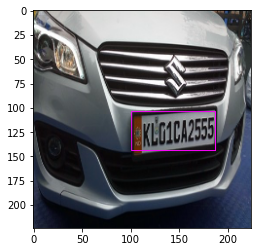

In [91]:
#Example with the first image of the dataset
image = cv2.rectangle(X[0],(y[0][0],y[0][1]),(y[0][2],y[0][3]),(255, 0, 255))
plt.imshow(image)
plt.show()


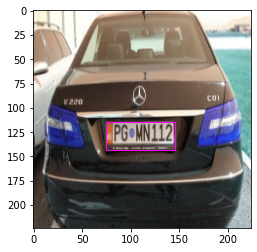

In [92]:
#Example with the second image of the dataset
image = cv2.rectangle(X[1],(y[1][0],y[1][1]),(y[1][2],y[1][3]),(255, 0, 255))
plt.imshow(image)
plt.show()


# Data Preprocessing and Train Test Split

In [93]:
#Transforming in array
X=np.array(X)
y=np.array(y)

In [94]:
#Renormalisation
X = X / 255
y = y / 255

We split our dataset in two : training set/testing set

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

# Using CNN With Keras

In [95]:
model = Sequential()
model.add(Conv2D(64 , (3,3) , input_shape=(224,224,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.1))

model.add(Conv2D(32 , (3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
train = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=1)

Epoch 1/50
11/11 [==============================] - 0s 41ms/step - loss: 0.1855 - accuracy: 0.1629 - val_loss: 0.1768 - val_accuracy: 0.0000e+00
Epoch 2/50
11/11 [==============================] - 0s 32ms/step - loss: 0.0705 - accuracy: 0.0000e+00 - val_loss: 0.0314 - val_accuracy: 0.3077
Epoch 3/50
11/11 [==============================] - 0s 33ms/step - loss: 0.0275 - accuracy: 0.2171 - val_loss: 0.0298 - val_accuracy: 0.4872
Epoch 4/50
11/11 [==============================] - 0s 31ms/step - loss: 0.0215 - accuracy: 0.5486 - val_loss: 0.0283 - val_accuracy: 0.4615
Epoch 5/50
11/11 [==============================] - 0s 33ms/step - loss: 0.0191 - accuracy: 0.5657 - val_loss: 0.0273 - val_accuracy: 0.5128
Epoch 6/50
11/11 [==============================] - 0s 31ms/step - loss: 0.0154 - accuracy: 0.6400 - val_loss: 0.0237 - val_accuracy: 0.7692
Epoch 7/50
11/11 [==============================] - 0s 32ms/step - loss: 0.0121 - accuracy: 0.7571 - val_loss: 0.0232 - val_accuracy: 0.7949
Epoch

# CNN Evaluation

In [96]:
# Test
scores = model.evaluate(X_test, y_test, verbose=0)
print("Score : %.2f%%" % (scores[1]*100))

Score : 63.64%


In [97]:
def plot_scores(train) :
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Score apprentissage')
    plt.plot(epochs, val_accuracy, 'r', label='Score validation')
    plt.title('Scores')
    plt.legend()
    plt.show()

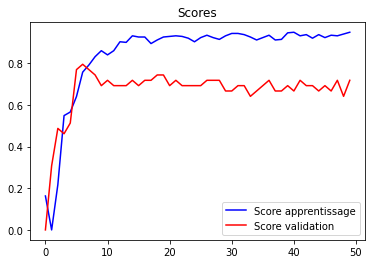

In [98]:
plot_scores(train)

In [100]:
from keras.callbacks import EarlyStopping

# Create the model
model = Sequential()
model.add(VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

# Freeze VGG16 base layers
model.layers[0].trainable = False

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# Train the model
train = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                  epochs=50, batch_size=32, verbose=1, callbacks=[early_stopping])


Epoch 1/50
11/11 [==============================] - 1s 89ms/step - loss: 0.0674 - accuracy: 0.3429 - val_loss: 0.0503 - val_accuracy: 0.4359
Epoch 2/50
11/11 [==============================] - 1s 75ms/step - loss: 0.0255 - accuracy: 0.4600 - val_loss: 0.0197 - val_accuracy: 0.5897
Epoch 3/50
11/11 [==============================] - 1s 71ms/step - loss: 0.0122 - accuracy: 0.5657 - val_loss: 0.0142 - val_accuracy: 0.7949
Epoch 4/50
11/11 [==============================] - 1s 70ms/step - loss: 0.0065 - accuracy: 0.6571 - val_loss: 0.0122 - val_accuracy: 0.8205
Epoch 5/50
11/11 [==============================] - 1s 70ms/step - loss: 0.0035 - accuracy: 0.8000 - val_loss: 0.0114 - val_accuracy: 0.8462
Epoch 6/50
11/11 [==============================] - 1s 67ms/step - loss: 0.0023 - accuracy: 0.8229 - val_loss: 0.0118 - val_accuracy: 0.8718
Epoch 7/50
11/11 [==============================] - 1s 72ms/step - loss: 0.0016 - accuracy: 0.8114 - val_loss: 0.0104 - val_accuracy: 0.8462
Epoch 8/50
11

In [101]:
# Test
scores = model.evaluate(X_test, y_test, verbose=0)
print("Score : %.2f%%" % (scores[1]*100))

Score : 72.73%


# Save Model

In [102]:
# Save the trained model
model.save("car_plate_detector.h5")

print("Model saved successfully!")

Model saved successfully!


# No Plate Detection System

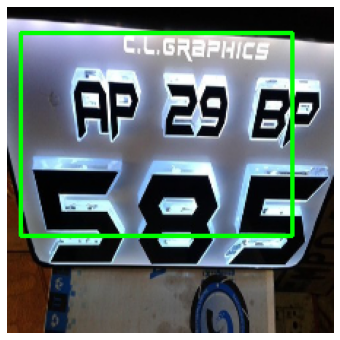

In [105]:
from tensorflow.keras.models import load_model
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the trained model
model = load_model("car_plate_detector.h5")


def detect_car_plate(image_path):
    # Load and preprocess the image
    img = cv2.imread(image_path)
    img_resized = cv2.resize(img, (224, 224))  # Resize to match model input
    img_normalized = img_resized / 255.0       # Normalize

    # Expand dimensions to match model input shape (1, 224, 224, 3)
    img_input = np.expand_dims(img_normalized, axis=0)

    # Predict bounding box
    pred = model.predict(img_input)[0]  # Get first (and only) prediction
    xmin, ymin, xmax, ymax = pred * 224  # Scale coordinates back

    # Draw rectangle on original image
    img_with_box = img_resized.copy()
    cv2.rectangle(img_with_box, 
                  (int(xmin), int(ymin)), 
                  (int(xmax), int(ymax)), 
                  (0, 255, 0), 2)

    # Display the result
    plt.figure(figsize=(6,6))
    plt.imshow(cv2.cvtColor(img_with_box, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

test_image = "/kaggle/input/car-plate-detection/images/Cars114.png"  # Replace with actual image path
detect_car_plate(test_image)

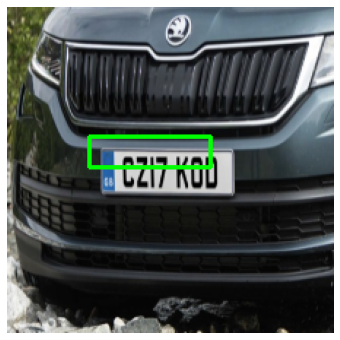

In [107]:
test_image = "/kaggle/input/car-plate-detection/images/Cars109.png"  # Replace with actual image path
detect_car_plate(test_image)

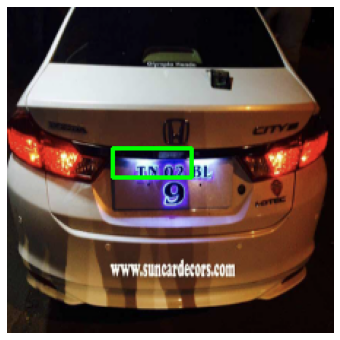

In [113]:
test_image = "/kaggle/input/car-plate-detection/images/Cars138.png"  # Replace with actual image path
detect_car_plate(test_image)

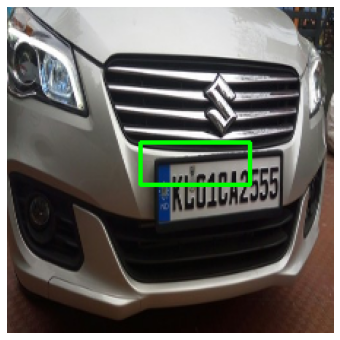

In [110]:
test_image = "/kaggle/input/car-plate-detection/images/Cars147.png"  # Replace with actual image path
detect_car_plate(test_image)